Section 2.3: Answer Quality Level Analysis

In [ ]:
import numpy as np
from icl.util_classes.arg_classes import AttrArgs
import matplotlib.pyplot as plt
import os
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator
import torch

font_path='xxx'
def generate_array(data, support_idxs, top_k, args):
    bsz=data.shape[0]
    new_data=np.empty_like(data[:,:-1,])
    for sample_idx in range(bsz):
        sample = data[sample_idx]
        sup_idxs=support_idxs[sample_idx]

        # psg->ans
        all_indices = np.arange(args.psg_num)
        mask = ~np.isin(all_indices, sup_idxs[:len(sup_idxs)//2])
        neg_ans_indices = all_indices[mask]

        # psg->que
        all_indices = np.arange(args.psg_num,2*args.psg_num)
        mask = ~np.isin(all_indices, sup_idxs[len(sup_idxs)//2:])
        neg_que_indices = all_indices[mask]
        
        new_order = np.concatenate([sup_idxs[:len(sup_idxs)//2], neg_ans_indices, sup_idxs[len(sup_idxs)//2:], neg_que_indices])
        
        new_sample = sample[new_order]
        new_data[sample_idx] = new_sample
    
    proportions = {'sp_a':0, 'np_a':0, 'sp_q':0, 'np_q':0, 'q_a':0}
    for i in range(bsz):
        split_sup_len=len(support_idxs[i])//2
        proportions['sp_a']+=new_data[i,:split_sup_len,].mean(axis=0) 
        proportions['np_a']+=new_data[i,split_sup_len:args.psg_num,].mean(axis=0) 
        proportions['sp_q']+=new_data[i,args.psg_num:args.psg_num+split_sup_len,].mean(axis=0) 
        proportions['np_q']+=new_data[i,args.psg_num+split_sup_len:,].mean(axis=0) 
    proportions = {k: v/bsz for k,v in proportions.items()}
    proportions['q_a']=data[:,-1,].mean(axis=0) 
    proportions={k:v*top_k for k,v in proportions.items()}
    return proportions
    

def plot_ndarray(data, support_idxs, good_idxs, bad_idxs, args, tag, title_name, ax=None, idx=None):
    top_k=10
    new_support_idxs = [sorted([x for idx in sample_idxs for x in (idx,idx+args.psg_num)]) 
            for sample_idxs in support_idxs]

    data_focus = data[:, :2*args.psg_num+1, :]
    data_good = data_focus[good_idxs]
    data_bad = data_focus[bad_idxs]
    support_idxs_good = [new_support_idxs[i] for i in good_idxs]
    support_idxs_bad = [new_support_idxs[i] for i in bad_idxs]
    proportions_good=generate_array(data_good, support_idxs_good, top_k, args)
    proportions_bad=generate_array(data_bad, support_idxs_bad, top_k, args)
    if 'bar' in tag:
        colors = ['#add9e8', '#f9c15f']
        if idx%2==0:
            data = {
                'names': [r'$\mathcal{I}_{p^s,q}$', r'$\mathcal{I}_{p^s,t}$'],
                'x': np.array([0, 1]),
                'values_left': np.array([proportions_good['sp_q'].sum(),proportions_good['sp_a'].sum()]),
                'values_right': np.array([proportions_bad['sp_q'].sum(),proportions_bad['sp_a'].sum()])
            }
        else:
            data = {
                'names': [r'$\mathcal{I}_{p^n,q}$', r'$\mathcal{I}_{p^n,t}$'],
                'x': np.array([0, 1]),
                'values_left': np.array([proportions_good['np_q'].sum(),proportions_good['np_a'].sum()]),
                'values_right': np.array([proportions_bad['np_q'].sum(),proportions_bad['np_a'].sum()])
            }
        
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure 
        bar_width = 0.35
            
        for i in range(len(data['x'])):
            ax.bar(data['x'][i] - bar_width/2, data['values_left'][i], width=bar_width, 
                color=colors[0], label='Good Samples' if i == 0 and idx%2 == 1 else "")
            ax.bar(data['x'][i] + bar_width/2, data['values_right'][i], width=bar_width, 
                color=colors[1], label='Bad Samples' if i == 0 and idx%2==1 else "")

        ystep=2 if idx%2==0 else 1
        ax.set_ylim(bottom=0.0)  
        ax.yaxis.set_major_locator(MultipleLocator(ystep))  
        
        if idx%2 == 0:
            ax.set_ylabel('Information flow', fontproperties=FontProperties(fname=font_path, size=20))
        else:
            lines = []
            labels = []
            lines.append(plt.Rectangle((0,0),1,1, fc=colors[0]))
            labels.append('Good')
            lines.append(plt.Rectangle((0,0),1,1, fc=colors[1]))
            labels.append('Bad')
            ax.legend(lines, labels, loc='upper right', fontsize=14)

            ax.yaxis.tick_right()                
    
        ax.set_xlabel('')
        ax.set_xticks(data['x'])
        ax.set_xticklabels(data['names'], fontproperties=FontProperties(fname=font_path, size=20))
        ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3, color='gray')
        ax.set_title(' ',fontproperties=FontProperties(fname=font_path, size=30))
        return fig 
        
    elif 'line_layer' in tag:
        if 'good' in tag:
            fig_data=np.array([proportions_good['sp_a'],proportions_bad['sp_a'],proportions_good['sp_q'],proportions_bad['sp_q']])   # (4,32)
            names=[r'$\mathcal{I}_{p^s,a}-g$', r'$\mathcal{I}_{p^s,a}-b$', r'$\mathcal{I}_{p^s,q}-g$', r'$\mathcal{I}_{p^s,q}-b$']
            colors = ['#4682B4', '#B0C4DE', '#DAA520', '#FFA07A']

        else:
            fig_data=np.array([proportions_good['np_a'],proportions_bad['np_a'],proportions_good['np_q'],proportions_bad['np_q']])   # (4,32)
            names=[r'$\mathcal{I}_{p^n,a}-g$', r'$\mathcal{I}_{p^n,a}-b$', r'$\mathcal{I}_{p^n,q}-g$', r'$\mathcal{I}_{p^n,q}-b$']
            colors = ['#4682B4', '#B0C4DE', '#DAA520', '#FFA07A']
        
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure 
        fignum_map={0:'a',1:'b',2:'c'}
        for i in range(len(names)):
            ax.plot(fig_data[i], label=names[i], color=colors[i]) 
        ax.legend(prop=FontProperties(fname=font_path, size=12))
        ax.set_title(title_name, fontproperties=FontProperties(fname=font_path, size=22))
        ax.set_ylabel('Information flow', fontproperties=FontProperties(fname=font_path, size=16))
        ax.set_xlabel(f'Layer\n({fignum_map[idx]})', fontproperties=FontProperties(fname=font_path, size=16))
        return fig  
    else:
        raise ValueError('tag must be bar/line_layer')

(987, 22, 28)
(1000, 22, 28)
(999, 42, 28)


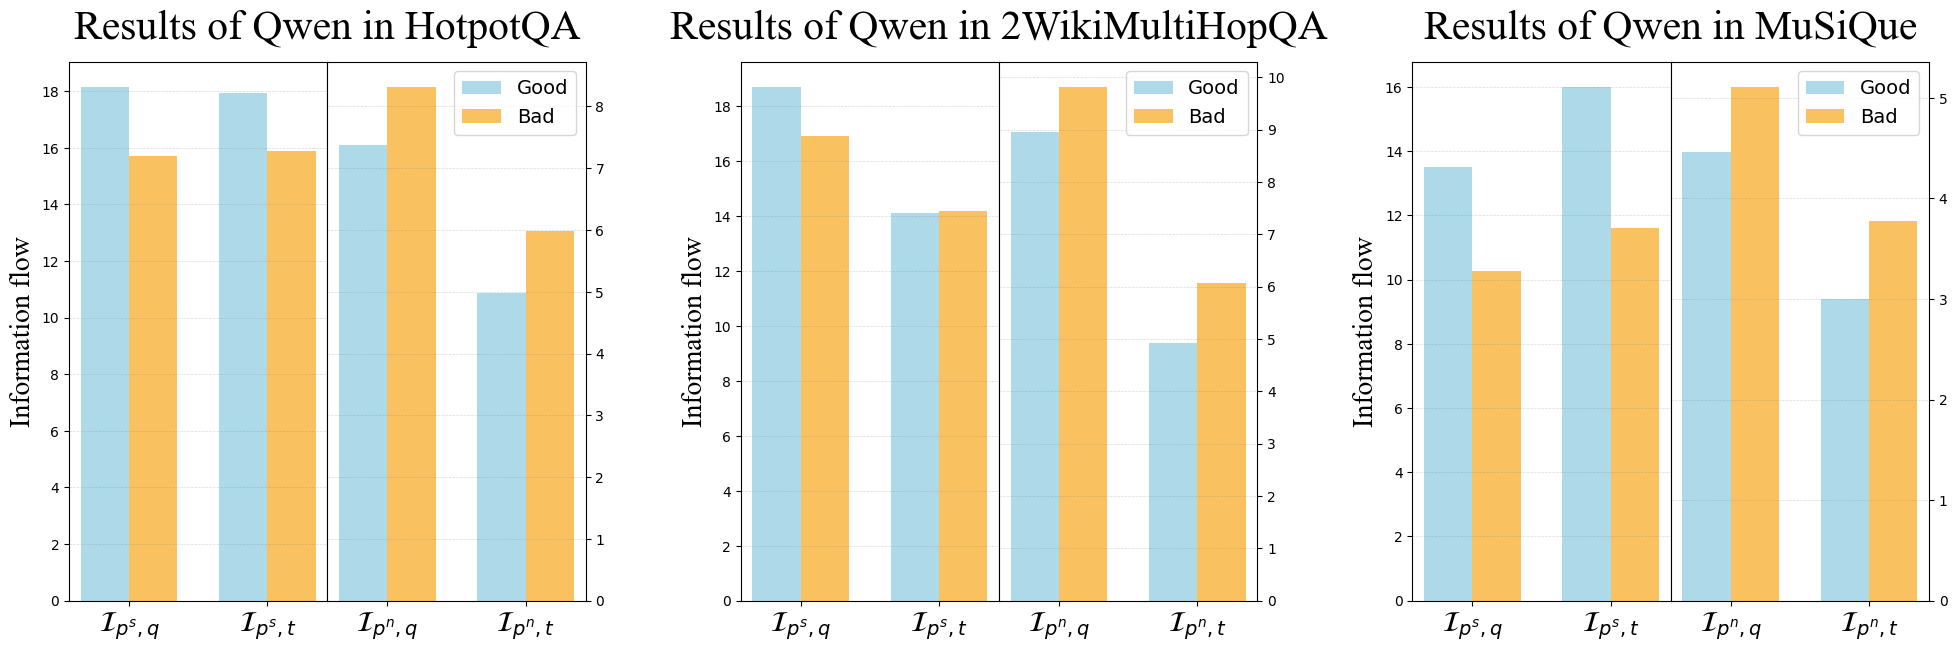

In [ ]:
model_name = 'qwen2.5-7b-instruct'    # 'qwen2.5-7b-instruct' 'llama-3.1-8b-instruct'
title_task_map={'hotpotqa':'HotpotQA','2wikimqa':'2WikiMultiHopQA','musique':'MuSiQue'}
title_model_map='Llama' if 'llama' in model_name else 'Qwen'
seed=42
tag='bar'

import json
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec

if 'line_layer' in tag:
    fig, axs = plt.subplots(1, 3, figsize=(24, 7))  
elif 'bar' in tag:
    fig = plt.figure(figsize=(24, 7))   
    axs=[]
    parent_gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.3)  
    for group in range(3):
        child_gs = parent_gs[group].subgridspec(1, 2, wspace=0)
        for col in range(2):
            ax = fig.add_subplot(child_gs[0, col])
            axs.append(ax)

tasks = ['hotpotqa', '2wikimqa', 'musique']  
for i, task in enumerate(tasks):
    res=[]
    res_good_idxs=[]
    res_bad_idxs=[]
    support_idxs=[]
    ana_args = AttrArgs(task_name=task, model_name=model_name, seeds=[seed])
    results = ana_args.load_result()
    print(results.shape)
    with open(f'{ana_args.save_file_name}.jsonl','r') as f:
        for line in f:
            res.append(json.loads(line))
    for j,obj in enumerate(res):
        support_idxs.append(obj['support_idxs'])
        if obj['label']=='Good':
            res_good_idxs.append(j)
        elif obj['label']=='Bad':
            res_bad_idxs.append(j)
    
    title_name = f'Results of {title_model_map} in {title_task_map[task]}'
    j=2 if 'bar' in tag else 1
    for _ in range(j):
        plot_ndarray(results,support_idxs,res_good_idxs,res_bad_idxs,ana_args,tag,title_name,ax=axs[j*i+_],idx=j*i+_)
    if 'line_layer' in tag:
        ystep=0.2 if title_model_map=='Llama' else 0.4
        axs[i].set_ylim(bottom=0.0)  
        axs[i].yaxis.set_major_locator(MultipleLocator(ystep))  
        axs[i].xaxis.set_major_locator(MultipleLocator(4))


if 'bar' in tag:
    group_labels = [f'Results of {title_model_map} in {title_task_map[task]}' for task in tasks]
    for group in range(3):
        bbox = parent_gs[group].get_position(fig)
        x_center = (bbox.x0 + bbox.x1) / 2 
        y_top = bbox.y1 + 0.02 
        
        fig.text(x_center, y_top, group_labels[group], 
                ha='center', va='bottom', 
                fontproperties=FontProperties(fname=font_path, size=30)) 
    plt.subplots_adjust(wspace=0.5)
else:
    plt.tight_layout(w_pad=2.0)

save_file=f'results/pics/quality/{model_name}/{tag}.pdf'
os.makedirs(os.path.dirname(save_file), exist_ok=True)
fig.savefig(save_file, bbox_inches='tight')


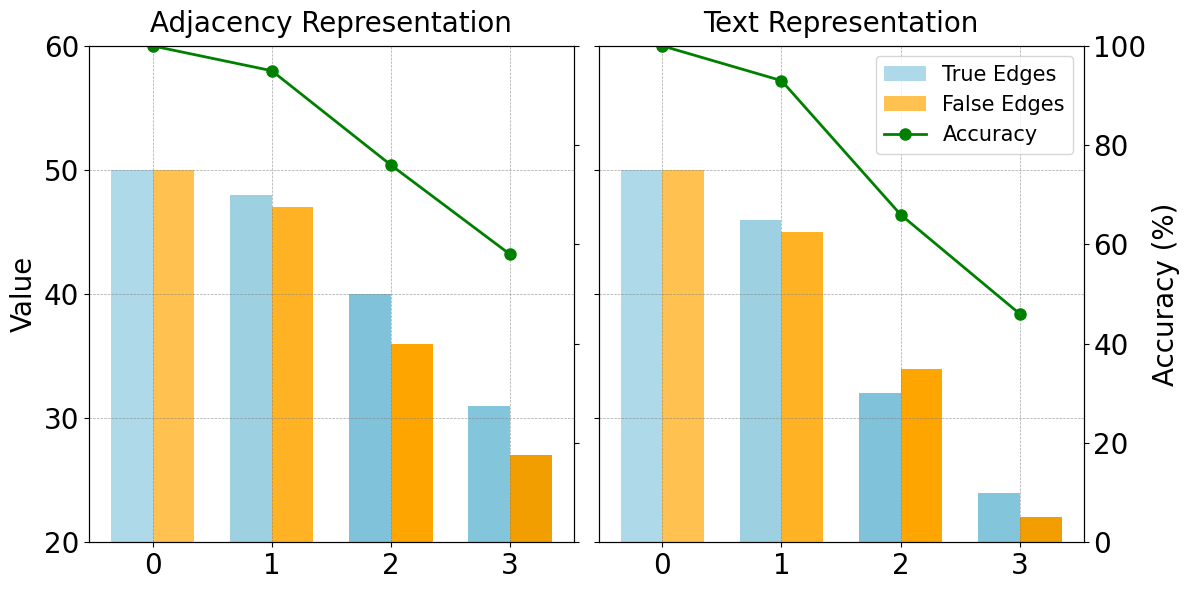

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], wspace=0.3, hspace=0.5)

# 定义每组子图的标题
group_labels = ['Group 1', 'Group 2', 'Group 3']

for i in range(3):
    # 每组包含两个并列子图
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])
    
    # 绘制数据（示例）
    ax1.plot(np.random.rand(10), color='blue')
    ax2.scatter(np.random.rand(10), np.random.rand(10), color='red')
    
    # 添加组标题（居中显示在两组上方）
    fig.text(0.5, 0.85 - i*0.3, group_labels[i], 
             ha='center', va='center', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()